# Detecting Outliers with Cleanlab's outlier detection algorithm

This is a summary of what this notebook does

**Overview of what we'll do in this tutorial:**
- load pretrained HuggingFace vision model
- use model to identify and rank outliers in our dataset
- analyze results

## 1. Install the required dependencies
You can use `pip` to install all packages required for this tutorial as follows:

```ipython3
!pip install torch
!pip install cleanlab
...
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [84]:
# Package installation (hidden on docs website).
# If running on Colab, may want to use GPU (select: Runtime > Change runtime type > Hardware accelerator > GPU)

dependencies = ["cleanlab", "matplotlib", "torch", "pylab", "keras", "sklearn", "timm", ]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

Lets first set some seeds for reproducibility

In [85]:
import numpy as np
import torch
import warnings

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

## 2. Fetch and scale the Cifar10 dataset

In [86]:
import matplotlib.pyplot as plt
from pylab import rcParams

from keras.datasets import cifar10, cifar100
from sklearn.model_selection import train_test_split

In [87]:
# load cifar10 datasets
(trainX, trainy), (testX, testy) = cifar10.load_data()
trainX, _, trainy, _ = train_test_split(trainX, trainy, test_size=0.5, stratify=trainy, random_state=SEED) # only use 50% of each label

# convert from integers to floats and normalize range 0-1
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

# remove non-animals out of the training dataset
animal_labels = [2,3,4,5,6,7]
animal_idxs = np.where(np.isin(trainy, animal_labels))[0] # find idx of animals
trainX = trainX[animal_idxs]
trainy = trainy[animal_idxs]

# check the shapes of our training and test sets
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(15000, 32, 32, 3), y=(15000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


#### Lets visualize some of the training and test examples
Plot a couple of the training images, observe how there are only animals left in the training set.

In [88]:
txt_labels = {0: 'airplane', 
              1: 'automobile', 
              2: 'bird',
              3: 'cat', 
              4: 'deer', 
              5: 'dog', 
              6: 'frog', 
              7: 'horse', 
              8:'ship', 
              9:'truck'}

def plot_images(X,y):
    plt.rcParams["figure.figsize"] = (9,7)
    for i in range(15):
        # define subplot
        ax = plt.subplot(3,5,i+1)
        ax.set_title(txt_labels[int(y[i])])
        # plot raw pixel data
        ax.imshow(X[i])
    # show the figure
    plt.show()

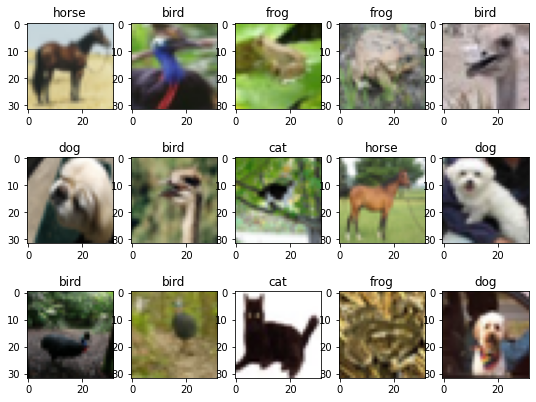

In [89]:
plot_images(trainX,trainy)

The test set on the other hand still contains the non-animal images: airplanes, automobile, ship, truck

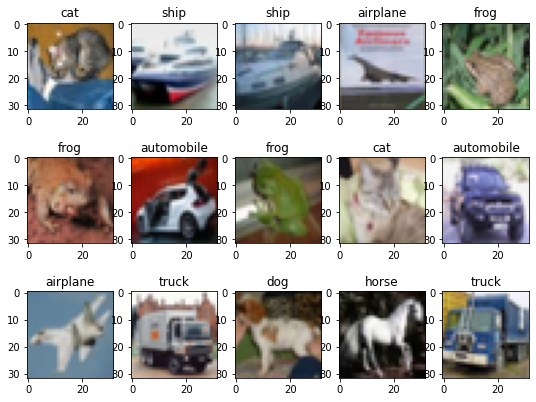

In [90]:
plot_images(testX,testy)

## 3. Import a model and embeddings
The model we are importing comes from `timm` (`timm` is a deep-learning library created by Ross Wightman and is a collection of SOTA models and utilities).

The model itself is a `resnet50`. This can be done with any model capable of generating feature embeddings (which we can then use as representations to define the indistribution content.

In [91]:
%%time
import timm

model = timm.create_model('resnet50', pretrained=True, num_classes=0) # download the model from timm
trainX_torch = torch.from_numpy(trainX.swapaxes(1,3)) # turn trainX into tensor and fix channel dimension
train_feature_embeddings = model(trainX_torch) # fit model to train images and get train embeddings
train_feature_embeddings = train_feature_embeddings.detach().numpy() # change type to numpy array
print(f'Pooled shape: {train_feature_embeddings.shape}')

Pooled shape: (15000, 2048)
CPU times: user 2min 33s, sys: 40.5 s, total: 3min 13s
Wall time: 1min 43s


In [92]:
%%time
model = timm.create_model('resnet50', pretrained=True, num_classes=0) # download the model from timm
testX_torch = torch.from_numpy(testX.swapaxes(1,3)) # turn trainX into tensor and fix channel dimension
test_feature_embeddings = model(testX_torch) # fit model to train images and get train embeddings
test_feature_embeddings = test_feature_embeddings.detach().numpy() # change type to numpy array
print(f'Pooled shape: {test_feature_embeddings.shape}')

Pooled shape: (10000, 2048)
CPU times: user 1min 54s, sys: 26.9 s, total: 2min 20s
Wall time: 1min 17s


## 4. Import cleanlab and find outliers in the dataset
We can use the `cleanlab` library to try and find the artificially added outlier examples (airplanes, automobiles, boats) in the test data. We can also check the training data to find any naturally occuring outlier examples in the dataset.

In [93]:
import cleanlab
from cleanlab.rank import get_outlier_scores
from sklearn.neighbors import NearestNeighbors # import KNN estimator

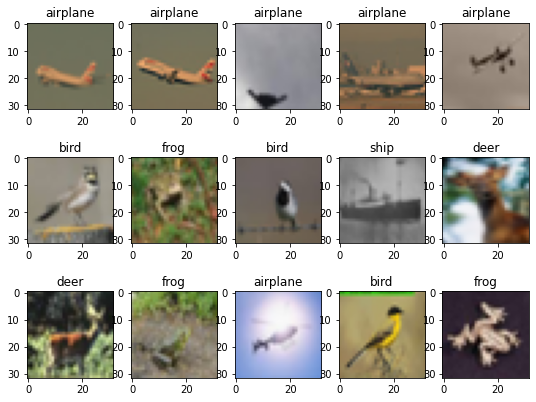

In [94]:
# import KNN estimator and fit it on the resnet50 feature embeddings
knn = NearestNeighbors(n_neighbors=10).fit(train_feature_embeddings)

# get outlier scores for the test feature embeddings
outlier_scores = get_outlier_scores(features=test_feature_embeddings, knn=knn, k=10)

# visualize top 15 outlier scores
top_outlier_idxs = (-outlier_scores).argsort()[:15]
plot_images(testX[top_outlier_idxs],testy[top_outlier_idxs])

Notice how majority of the outliers belong to the holdout classes (airplane, automobile, ship). These feature representations are futher away in the model representation space than the training dataset representations. 

Just for fun, lets visualize what the NearestNeighbors algorithm considers the 15 least probable outliers in our test set. Notice there are a lot less images from the houldout classes here.

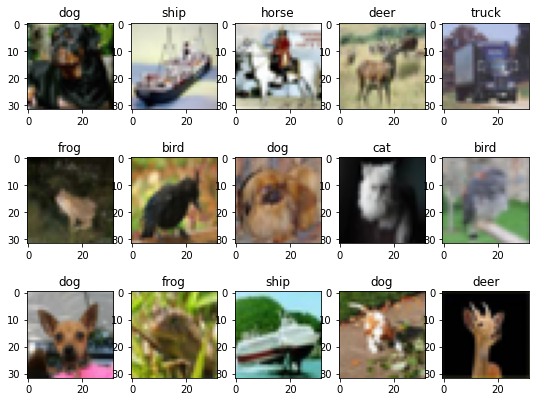

In [95]:
# visualize top 15 outlier scores
top_outlier_idxs = (outlier_scores).argsort()[:15]
plot_images(testX[top_outlier_idxs],testy[top_outlier_idxs])

We can also compute the precision/recall of our algorithm for the examples. [Jonas is this important?]

In [96]:
from sklearn.metrics import precision_recall_curve
animal_labels = [2,3,4,5,6,7] # identify animal labels in the testing dataset
animal_idxs = np.where(np.isin(testy, animal_labels))[0] # find idx of animals
not_outlier = np.zeros(len(testy), dtype=bool) # is outlier
not_outlier[animal_idxs] = True
precision, recall, thresholds = precision_recall_curve(not_outlier, 1 - outlier_scores)

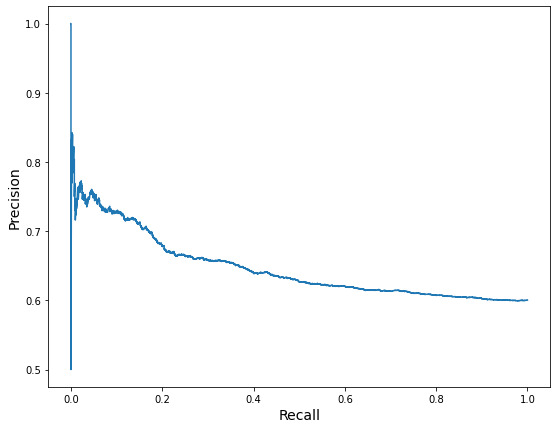

In [97]:
plt.plot(recall, precision)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.show()

### Finding naturally occuring outlier examples

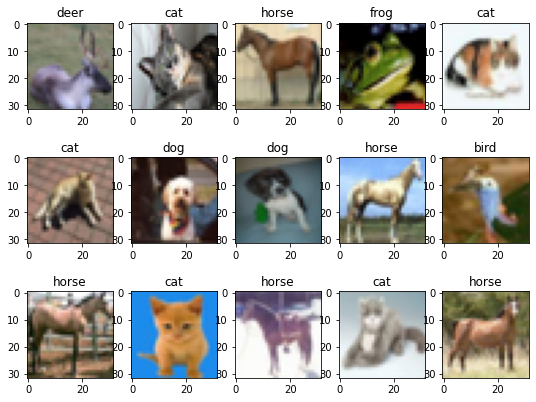

In [98]:
# get outlier scores for our train feature embeddings
outlier_scores = get_outlier_scores(features=train_feature_embeddings, k=10)

# visualize top 15 outlier scores
top_outlier_idxs = (-outlier_scores).argsort()[:15]
plot_images(trainX[top_outlier_idxs],trainy[top_outlier_idxs])

Just for fun, lets see what our model considers the least likeley outliers in the training and test sets.

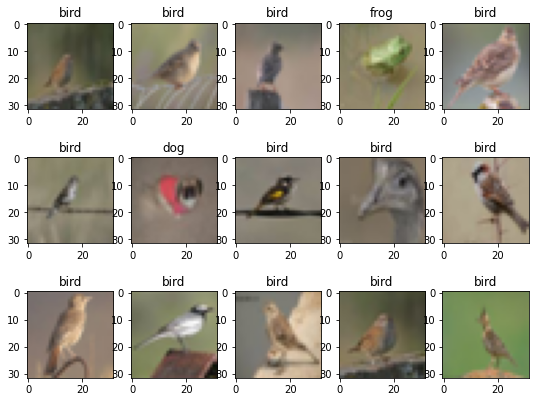

In [101]:
# visualize bottom 12 outlier scores on train set
top_outlier_idxs = (outlier_scores).argsort()[:15]
plot_images(trainX[top_outlier_idxs],trainy[top_outlier_idxs])

In [ ]:
# TODO: Cleanlab can discover two kinds of labels for you! "what if our training data contained SOME outliers (little)"
# add a couple outliers to the training (map these labels to training stuff + flip cifar10 labels? same %)

In [ ]:
# # TODO: Add test cell
# # Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

# highlighted_indices = [59915, 24798, 59701, 50340]  # verify these examples were found by find_label_issues
# if not all(x in ranked_label_issues for x in highlighted_indices):
#     raise Exception("Some highlighted examples are missing from ranked_label_issues.")
    